# Survival on the Titanic

This report investigates the data included in the dataset titanic_data.csv, downloaded from [Udacity](https://www.udacity.com/)  for the final project of the [Intro to Data Analysis](https://www.udacity.com/course/intro-to-data-analysis--ud170) free course.

The questions that this report tries to answer are: which factors were predictive of survival on the Titanic and can we build a model based on these factors to predict survival? The factors that were investigated include:
- Ticket class
- Sex
- Age
- Number of siblings/ spouses aboard
- Number of parents/ children aboard
- Passenger fare
- Port of embarkation

The report uses a Logistic Regression model to investigate the factors that best predict survival.

For more detailed information on the dataset please visit [Kaggle](https://www.kaggle.com/c/titanic/data), which is where Udacity obtained the data.

The Logistic Regression model and analysis in this report were created with references to the guides written by Susan Li on [Medium](https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8), Kevin Markham's example on [Data School](http://www.dataschool.io/logistic-regression-in-python-using-scikit-learn/), and the blog post on [Data-Mania](http://www.data-mania.com/blog/logistic-regression-example-in-python/).

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

%matplotlib inline

## Load Data from CSV

In [30]:
# Read in the data from titanic_data.csv and store it in the variable 'titanic'
titanic = pd.read_csv('titanic_data.csv', usecols=['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])

titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [31]:
# Check missing values
titanic.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [32]:
# Calculate mean age by Pclass
titanic.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [33]:
# Function to estimate age for missing age values in data based on Pclass
def estimate_age(data):
    age = data[0]
    pclass = data[1]
    if pd.isnull(age):
        if pclass == 1:
            return 38
        elif pclass == 2:
            return 30
        elif pclass == 3:
            return 25
    else:
        return age
    
titanic['Age'] = titanic[['Age', 'Pclass']].apply(estimate_age, axis=1)
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [34]:
# Remove data rows with missing Embarked data
titanic.dropna(inplace=True)
titanic.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Investigating the Data

In [35]:
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.218414,0.524184,0.382452,32.096681
std,0.486260,0.834700,13.178017,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,36.500000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


0    549
1    340
Name: Survived, dtype: int64


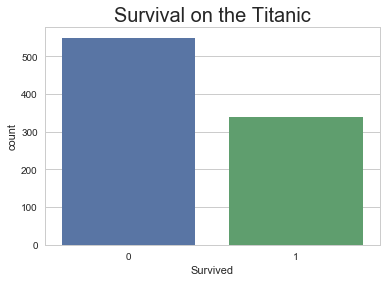

In [36]:
# A look at total number survived (1) vs. did not survive (0)
print(titanic['Survived'].value_counts())

ax = sns.countplot(x='Survived', data=titanic)
ax.set_title('Survival on the Titanic', fontsize=20)
plt.show()

In [37]:
# Group the passengers by survival outcome and look at the mean of numerical variables
titanic_by_survival = titanic.groupby('Survived')

titanic_by_survival.mean()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,2.531876,29.787796,0.553734,0.329690,22.117887
1,1.955882,28.299029,0.476471,0.467647,48.209498


In [38]:
# Proportion of males and females survived vs did not survive
table_sex = pd.crosstab(titanic.Survived, titanic.Sex)
table_sex_prop = table_sex.div(table_sex.sum(1), axis=0)
table_sex_prop

Sex,female,male
Survived,,
0,0.147541,0.852459
1,0.679412,0.320588


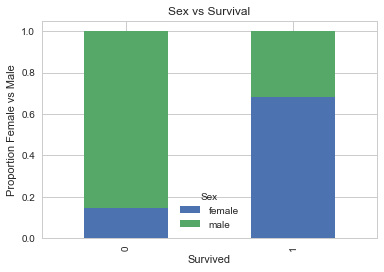

In [39]:
# Stacked barplot
table_sex_prop.plot.bar(stacked=True)
plt.title('Sex vs Survival')
plt.ylabel('Proportion Female vs Male')
plt.show()

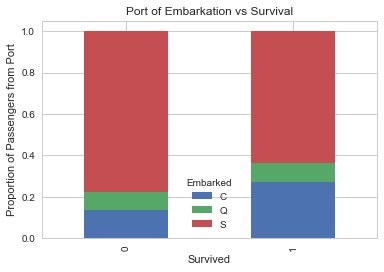

In [40]:
# Compare port of embarkation proportions for survival outcomes
table_embark = pd.crosstab(titanic.Survived, titanic.Embarked)
table_embark_prop = table_embark.div(table_embark.sum(1), axis=0).plot.bar(stacked=True)
plt.title('Port of Embarkation vs Survival')
plt.ylabel('Proportion of Passengers from Port')
plt.show()

### Initial Observations

- There were more passengers that did not survive than those that did
- The average ticket class was higher (with the assumption that this refers to a lower socioeconomic class) for those who did not survive compared to those who did
- The average age and number of siblings or spouses aboard were higher for those who did not survive
- The average number of parents/ children aboard and value of the fare paid were lower for those who did not survive
- A higher proportion of females survived compared to males
- A higher proportion of passengers who embarked from Cherbourg appear have survived vs not survived, and a lower proportion of passengers from Southampton appear to have survived vs not survived

# Logistic Regression Model

Below is a logistic regression on the data, with 'Survived' as the dependent variable and ticket class, sex, age, number of siblings/ spouses aboard, number of parents/ children aboard, passenger fare, and port of embarkation as the independent variables.

In [41]:
# Create dummy variables for sex and port of embarkation
sex = pd.get_dummies(titanic['Sex'], drop_first=True)
embark = pd.get_dummies(titanic['Embarked'], drop_first=True)
titanic.drop(['Sex', 'Embarked'], axis=1, inplace=True)
titanic_dummy = pd.concat([titanic, sex, embark], axis=1)
titanic_dummy.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [42]:
# Split data into training and test sets
y = titanic_dummy.iloc[:,0]
X = titanic_dummy.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [43]:
# Logistic Regression model
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
print("Accuracy of model on test set: {}".format(model.score(X_test, y_test)))

Accuracy of model on test set: 0.8164794007490637


In [44]:
no_survival_model = 1 - y.mean()
print("If our model simply predicted all passengers did not survive, the accuracy would be: {}".format(no_survival_model))

If our model simply predicted all passengers did not survive, the accuracy would be: 0.6175478065241844


Based on the model's accuracy of 82% compared to 62% for a model predicting "did not survive" for every passenger, it's clear that the Logistic Regression model is performing better than blindly predicting no survival.

In [45]:
# Examine the coefficients
pd.DataFrame(dict(zip(X.columns, np.transpose(model.coef_))))

,Age,Fare,Parch,Pclass,Q,S,SibSp,male
0,-0.032364,0.0078,-0.068488,-0.788476,-0.196184,-0.21042,-0.34284,-2.217317


By examing these coefficients, we can see, based on the model, that:

- Increases in age, number of parents/ children onboard, ticket class, and number of siblings/spouses onboard decreased the likelihood of survival
- An increase in the passenger fare increased likelihood of survival
- The highest likelihood of survival was for those who embarked from Cherbourg as opposed to the two other ports, since both dummy coefficients are negative
- Females were more likely to survive than males

In [46]:
# Confusion matrix
y_pred = model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))

[[150  19]
 [ 30  68]]


Based on the confusion matrix above, the model resulted in 218 correct predictions and 49 incorrect predictions on the test set.

In [47]:
# Classification report
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.89      0.86       169
          1       0.78      0.69      0.74        98

avg / total       0.81      0.82      0.81       267



### Predicting Probability of Survival

A prediction of the probability of survival for a 23 year old female, with 1 spouse/ sibling aboard, 0 children/ parents aboard, ticket class 2, a fare of $14.05, and embarkation from Southampton.

In [48]:
model.predict_proba(np.array([[2, 23.0, 1, 0, 14.05, 0, 0, 1]]))

array([[ 0.27079717,  0.72920283]])

The predicted probability of survival is 73%.

# Further Analysis

Going forward the analysis done here can be taken further by:

- Using other models
- Recreating the model with some features removed
- Using RFE to narrow the model down to the 5 features most essential to the model